In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# LangGraph Agent 개발 

## Tool 정의

In [3]:
from langchain_teddynote.tools.tavily import TavilySearch

In [4]:
# 도구 정의 
tool = TavilySearch(max_results=5)

# 도구 목록 반영
tools = [tool]

In [5]:
# 도구 실행
print(tool.invoke("LangGraph Tutorial"))

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial', 'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?', 'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactions.', 'score': 0.91137725, 'raw_content': '# LangGraph Tutorial: What Is LangGraph and How to Use It?\n\nLangGra

### LLM + Tools

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [7]:
# State 정의 
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [8]:
# LLM 정의 
llm = ChatOpenAI(model = 'gpt-4o-mini', temperature=0)

In [9]:
# LLM + Tools 
llm_with_tools = llm.bind_tools(tools)

### Node

In [10]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    return {"messages": [answer]} 

### Graph

In [11]:
from langgraph.graph import StateGraph

In [12]:
# 그래프 초기화 
graph_builder = StateGraph(State)

In [13]:
# 노드 연결
graph_builder.add_node("chatbot", chatbot)

## Tool Node 

- 도구가 호출될 경우 실제로 실행할 수 있는 함수 
- 가장 최근의 메시지를 확인하고 메시지에 `tool_calls`가 포함되어 있으면 도구를 호출하는 `BasicToolNode` 구현 
- 아래 코드 블럭은 이해를 돕기 위해 직접 구현. 이후에는 LangGraph의 ToolNode로 대체함 
- [Reference]https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode

In [14]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        # 주어진 도구 리스트를 이름(name)을 기준으로 딕셔너리 형태로 변환
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        # inputs 딕셔너리에서 "messages" 키의 값을 가져옴 (없으면 빈 리스트 반환)
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 실행 결과를 저장할 리스트
        outputs = []

        # message 객체 안의 tool_calls 속성에는 LLM이 호출 요청한 도구 정보가 리스트로 저장되어 있음
        for tool_call in message.tool_calls:
            # 도구 이름으로 실제 도구 인스턴스를 가져와서, 전달된 인자(args)를 사용해 실행
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])

            # 도구 호출 후 결과 저장
            # 도구 실행 결과를 문자열(JSON 형식)로 변환하여 ToolMessage 객체로 저장
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

## Conditional Edge

- 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅 
- 이러한 함수는 현재 그래프 `state`를 받아 다음에 호출할 Node 를 나타내는 **문자열 또는 문자열 목록** 을 반환

- 아래에서는 `route_tools`라는 라우터 함수를 정의하여 챗봇의 출력에서 `tool_calls`를 확인
- 이 함수를 `add_conditional_edges`를 호출하여 그래프에 제공하면, `chatbot` 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 갈지 결정
- 조건은 도구 호출이 있으면 `tools`로, 없으면 `END`로 라우팅

- [Reference] tools_condition
https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition

In [15]:
from langgraph.graph import START, END

In [16]:
def route_tools(
    state: State,
):  
    # state에서 "messages" 키를 통해 메시지 리스트를 가져옴
    # messages는 지금까지 주고받은 대화 기록 (주로 AIMessage, HumanMessage 등)
    if messages := state.get("messages", []):
        ai_message = messages[-1] # 가장 최근 AI 메시지 추출
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # 가장 최근 메시지에 tool_calls 속성이 있고, 실제 호출 요청이 하나 이상 존재하면
    # 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END

In [17]:
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    path_map={
        "tools":"tools",
        END:END,
    }
)

In [18]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [19]:
graph = graph_builder.compile()

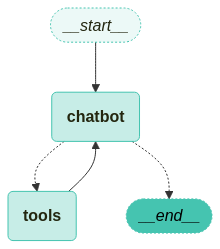

In [22]:
from langchain_teddynote.graphs import visualize_graph
visualize_graph(graph)

In [20]:
print(graph.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
        +---------+           
        | chatbot |           
        +---------+           
         *         .          
       **           ..        
      *               .       
+-------+         +---------+ 
| tools |         | __end__ | 
+-------+         +---------+ 


In [21]:
inputs = {"messages": "SK AX에서 진행하는 SKALA에 대해서 검색해 주세요"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        print(value[-1])


STEP: messages

content='SK AX에서 진행하는 SKALA에 대해서 검색해 주세요' id='d4064aa4-f82f-4142-9b52-05ac5f605ea1'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_OVeaUgNoTCO5TE0PRTHrABgu', 'function': {'arguments': '{"query":"SK AX SKALA"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 103, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f5a527a8-a155-478f-b6ea-abc498171e5e-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'SK AX SKALA'}, 'id': 'call_OVeaUgNoTCO5TE0PRTHrABgu', 'type': 'tool_call'}] usage_metadata={'input_tokens': 103, 'output_tokens':

## LangSmith Trace

-----
** End of Documents **